<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/Transformer_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow import keras
from keras_nlp.layers import TransformerEncoder, TransformerDecoder
from tensorflow.keras.layers import Input, Embedding, Dense, Dot, Activation, Concatenate ,Dropout, LayerNormalization , Layer
import matplotlib.pyplot as plt


# Create data

In [2]:
date_range = pd.date_range(start="2023-01-01", end="2025-12-31", freq="D") #วันที่ 2 ปี

days = np.arange(len(date_range))
temperature = 25 + 5 * np.sin(2 * np.pi * days / 365) + np.random.normal(0, 2, len(days))
humidity = 60 + 10 * np.cos(2 * np.pi * days / 365) + np.random.normal(0, 5, len(days))
np.random.seed(42)

df = pd.DataFrame({
    "date": date_range,
    "temperature": temperature,
    "humidity": humidity
})

# แสดงตัวอย่างข้อมูล
df.head(10)


,date,temperature,humidity
0,2023-01-01,23.904088,74.550934
1,2023-01-02,27.271508,67.877623
2,2023-01-03,22.162032,66.383299
3,2023-01-04,24.119550,69.620109
4,2023-01-05,27.075075,69.869428
5,2023-01-06,24.452249,77.847920
6,2023-01-07,25.879194,73.122135
7,2023-01-08,26.505617,70.366745
8,2023-01-09,26.394449,64.536026
9,2023-01-10,26.124935,77.774803


array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>]], dtype=object)

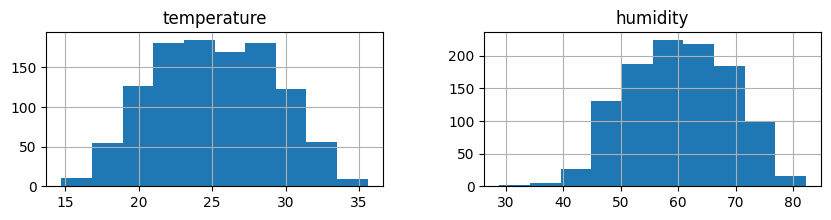

In [3]:
df.iloc[:,1:].hist(figsize=(10,2))

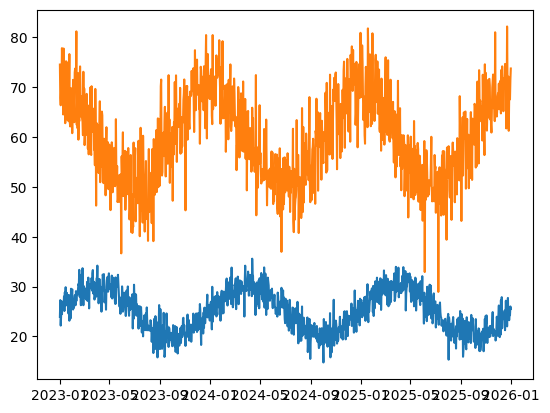

In [4]:
plt.plot(df['date'], df['temperature'])
plt.plot(df['date'], df['humidity'])

# Data prepartation for train model

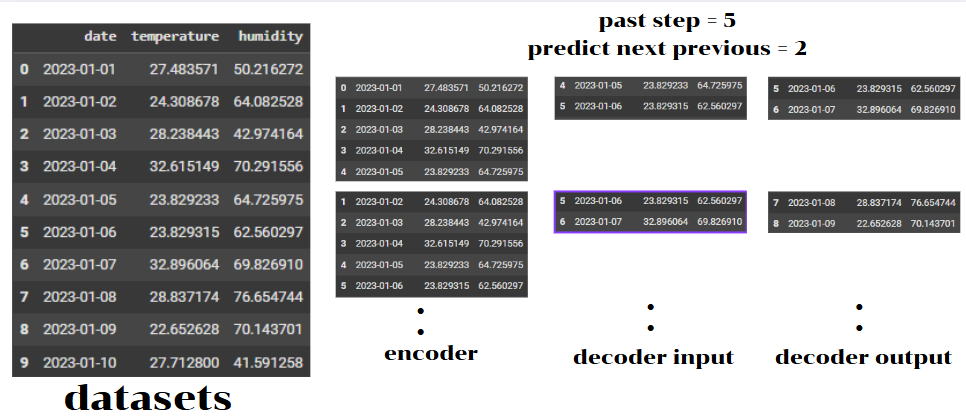

In [148]:
len(df)

1096

In [149]:
encoder_timesteps = 5  # ใช้ข้อมูลย้อนหลัง 5 วัน
decoder_timesteps = 2    # ทำนายอนาคต 2 วัน

X_encoder, Y_decoder_input, Y_decoder_output = [], [], []

for i in range(len(df) - encoder_timesteps - decoder_timesteps):
    # Encoder input (5 วันก่อนหน้า)          # 0 1 2 3 4
    X_encoder.append(df.iloc[i : i + encoder_timesteps][["temperature", "humidity"]].values)

    # Decoder input (ใช้ค่าจริงของ 2 วันถัดไป) # 4 5
    Y_decoder_input.append(df.iloc[i + encoder_timesteps-1 : (i + encoder_timesteps-1) + decoder_timesteps][["temperature", "humidity"]].values)

    # Decoder output (ค่าที่ต้องทำนาย)       # 5 6
    Y_decoder_output.append(df.iloc[i + encoder_timesteps: i + encoder_timesteps + decoder_timesteps][["temperature", "humidity"]].values)

# แปลงเป็น NumPy array
X_encoder = np.array(X_encoder)
Y_decoder_input = np.array(Y_decoder_input)
Y_decoder_output = np.array(Y_decoder_output)

# ตรวจสอบขนาดของข้อมูล
X_encoder.shape, Y_decoder_input.shape, Y_decoder_output.shape


((1089, 5, 2), (1089, 2, 2), (1089, 2, 2))

In [150]:
X_encoder[:3] , '**********************************************', Y_decoder_input[:1], '**********************************************', Y_decoder_output[:1]

(array([[[23.90408823, 74.55093378],
         [27.27150766, 67.87762289],
         [22.16203177, 66.38329911],
         [24.11955002, 69.62010888],
         [27.07507542, 69.86942815]],
 
        [[27.27150766, 67.87762289],
         [22.16203177, 66.38329911],
         [24.11955002, 69.62010888],
         [27.07507542, 69.86942815],
         [24.45224908, 77.84791977]],
 
        [[22.16203177, 66.38329911],
         [24.11955002, 69.62010888],
         [27.07507542, 69.86942815],
         [24.45224908, 77.84791977],
         [25.87919374, 73.12213523]]]),
 '**********************************************',
 array([[[27.07507542, 69.86942815],
         [24.45224908, 77.84791977]]]),
 '**********************************************',
 array([[[24.45224908, 77.84791977],
         [25.87919374, 73.12213523]]]))

# Data splitting and Normalization

In [151]:
X_train_enc, X_temp_enc    , Y_train_dec_in, Y_temp_dec_in ,     Y_train_dec_out, Y_temp_dec_out = train_test_split(
    X_encoder, Y_decoder_input, Y_decoder_output
    , test_size=0.5, shuffle=False
)

X_val_enc, X_test_enc,       Y_val_dec_in, Y_test_dec_in,       Y_val_dec_out, Y_test_dec_out = train_test_split(
    X_temp_enc, Y_temp_dec_in, Y_temp_dec_out
    , test_size=0.5, shuffle=False
)

print("Encoder Input Shapes:")
print(f"X_train_enc: {X_train_enc.shape}")
print(f"X_val_enc: {X_val_enc.shape}")
print(f"X_test_enc: {X_test_enc.shape}")

print("\nDecoder Input Shapes:")
print(f"Y_train_dec_in: {Y_train_dec_in.shape}")
print(f"Y_val_dec_in: {Y_val_dec_in.shape}")
print(f"Y_test_dec_in: {Y_test_dec_in.shape}")

print("\nDecoder Output Shapes:")
print(f"Y_train_dec_out: {Y_train_dec_out.shape}")
print(f"Y_val_dec_out: {Y_val_dec_out.shape}")
print(f"Y_test_dec_out: {Y_test_dec_out.shape}")


Encoder Input Shapes:
X_train_enc: (544, 5, 2)
X_val_enc: (272, 5, 2)
X_test_enc: (273, 5, 2)

Decoder Input Shapes:
Y_train_dec_in: (544, 2, 2)
Y_val_dec_in: (272, 2, 2)
Y_test_dec_in: (273, 2, 2)

Decoder Output Shapes:
Y_train_dec_out: (544, 2, 2)
Y_val_dec_out: (272, 2, 2)
Y_test_dec_out: (273, 2, 2)


In [152]:
scaler_enc = MinMaxScaler()
scaler_dec = MinMaxScaler()

X_train_enc_scaled = scaler_enc.fit_transform(X_train_enc.reshape(-1, X_train_enc.shape[-1])).reshape(X_train_enc.shape)
X_val_enc_scaled = scaler_enc.transform(X_val_enc.reshape(-1, X_val_enc.shape[-1])).reshape(X_val_enc.shape)
X_test_enc_scaled = scaler_enc.transform(X_test_enc.reshape(-1, X_test_enc.shape[-1])).reshape(X_test_enc.shape)

Y_train_dec_in_scaled = scaler_dec.fit_transform(Y_train_dec_in.reshape(-1, Y_train_dec_in.shape[-1])).reshape(Y_train_dec_in.shape)
Y_val_dec_in_scaled = scaler_dec.transform(Y_val_dec_in.reshape(-1, Y_val_dec_in.shape[-1])).reshape(Y_val_dec_in.shape)
Y_test_dec_in_scaled = scaler_dec.transform(Y_test_dec_in.reshape(-1, Y_test_dec_in.shape[-1])).reshape(Y_test_dec_in.shape)

Y_train_dec_out_scaled = scaler_dec.transform(Y_train_dec_out.reshape(-1, Y_train_dec_out.shape[-1])).reshape(Y_train_dec_out.shape)
Y_val_dec_out_scaled = scaler_dec.transform(Y_val_dec_out.reshape(-1, Y_val_dec_out.shape[-1])).reshape(Y_val_dec_out.shape)
Y_test_dec_out_scaled = scaler_dec.transform(Y_test_dec_out.reshape(-1, Y_test_dec_out.shape[-1])).reshape(Y_test_dec_out.shape)

print("After MinMax Scaling:")
print(f"X_train_enc_scaled: {X_train_enc_scaled.shape}")
print(f"X_val_enc_scaled: {X_val_enc_scaled.shape}")
print(f"X_test_enc_scaled: {X_test_enc_scaled.shape}")
print(f"Y_train_dec_in_scaled: {Y_train_dec_in_scaled.shape}")
print(f"Y_val_dec_in_scaled: {Y_val_dec_in_scaled.shape}")
print(f"Y_test_dec_in_scaled: {Y_test_dec_in_scaled.shape}")
print(f"Y_train_dec_out_scaled: {Y_train_dec_out_scaled.shape}")
print(f"Y_val_dec_out_scaled: {Y_val_dec_out_scaled.shape}")
print(f"Y_test_dec_out_scaled: {Y_test_dec_out_scaled.shape}")


After MinMax Scaling:
X_train_enc_scaled: (544, 5, 2)
X_val_enc_scaled: (272, 5, 2)
X_test_enc_scaled: (273, 5, 2)
Y_train_dec_in_scaled: (544, 2, 2)
Y_val_dec_in_scaled: (272, 2, 2)
Y_test_dec_in_scaled: (273, 2, 2)
Y_train_dec_out_scaled: (544, 2, 2)
Y_val_dec_out_scaled: (272, 2, 2)
Y_test_dec_out_scaled: (273, 2, 2)


# Transformer architecture

In [154]:
# ✅ 1️⃣ ตั้งค่าพารามิเตอร์หลักของ Transformer
d_model = 64        # ขนาดของเวกเตอร์ที่ใช้ใน Transformer (ต้องมากกว่า num_heads)
num_heads = 4       # จำนวนหัวของ Multi-Head Attention
dff = 128           # ขนาดของ Feed Forward Network (FFN) ใน Transformer
num_layers = 1      # จำนวนชั้นของ Encoder และ Decoder
input_seq_len = 5   # ความยาวของ sequence ฝั่ง Encoder (เช่น จำนวน time steps)
output_seq_len = 2  # ความยาวของ sequence ฝั่ง Decoder (เช่น จำนวน time steps ที่ต้องพยากรณ์)
num_features = 2    # จำนวนฟีเจอร์ของ Time Series (เช่น อุณหภูมิ, ความชื้น)

# ✅ 2️⃣ Encoder (เข้ารหัสข้อมูลต้นทาง)
encoder_inputs = keras.Input(shape=(input_seq_len, num_features))  # อินพุตของ Encoder (batch, time_steps, features)
x = keras.layers.Dense(d_model)(encoder_inputs)  # เปลี่ยนขนาดฟีเจอร์จาก `num_features` → `d_model`
x = TransformerEncoder(intermediate_dim=dff, num_heads=num_heads)(x)  # ใช้ Transformer Encoder
encoder_outputs = keras.layers.Dense(d_model)(x)  # อัปเดตขนาดของ Encoder Output

# ✅ 3️⃣ Decoder (ถอดรหัสเพื่อสร้างพยากรณ์)
decoder_inputs = keras.Input(shape=(output_seq_len, num_features))  # อินพุตของ Decoder (batch, time_steps, features)
x = keras.layers.Dense(d_model)(decoder_inputs)  # เปลี่ยนขนาดฟีเจอร์จาก `num_features` → `d_model`
x = TransformerDecoder(intermediate_dim=dff, num_heads=num_heads)(x, encoder_sequence=encoder_outputs)  # ใช้ Transformer Decoder
decoder_outputs = keras.layers.Dense(num_features)(x)  # แปลง output กลับเป็น `num_features` (พยากรณ์ค่า Time Series)

# ✅ 4️⃣ สร้างโมเดล Transformer
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43            │ (None, 5, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_107 (Dense)         │ (None, 5, 64)          │            192 │ input_layer_43[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_44            │ (None, 2, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_23    │ (None, 5, 64)          │         33,472 │ dense_107[0][0]        │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_109 (Dense)         │ (None, 2, 64)          │            192 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_108 (Dense)         │ (None, 5, 64)          │          4,160 │ transformer_encoder_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder_20    │ (None, 2, 64)          │         50,240 │ dense_109[0][0],       │
│ (TransformerDecoder)      │                        │                │ dense_108[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_110 (Dense)         │ (None, 2, 2)           │            130 │ transformer_decoder_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 88,386 (345.26 KB)

 Trainable params: 88,386 (345.26 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [155]:
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    alpha=0.1
)
optimizer = keras.optimizers.AdamW(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss="mse")
history = model.fit(
    [X_train_enc_scaled, Y_train_dec_in_scaled], Y_train_dec_out_scaled,
    validation_data=([X_val_enc_scaled, Y_val_dec_in_scaled], Y_val_dec_out_scaled),
    epochs=50,
    batch_size=64
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 1.0207 - val_loss: 0.2706
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1948 - val_loss: 0.1482
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0858 - val_loss: 0.0545
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0462 - val_loss: 0.0410
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0309 - val_loss: 0.0285
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0240 - val_loss: 0.0261
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0224 - val_loss: 0.0225
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0194 - val_loss: 0.0251
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0203 - val_loss: 0.0230
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0184 - val_loss: 0.0212
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0181 - val_loss: 0.0201
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0175 - val_loss: 0.0189
E

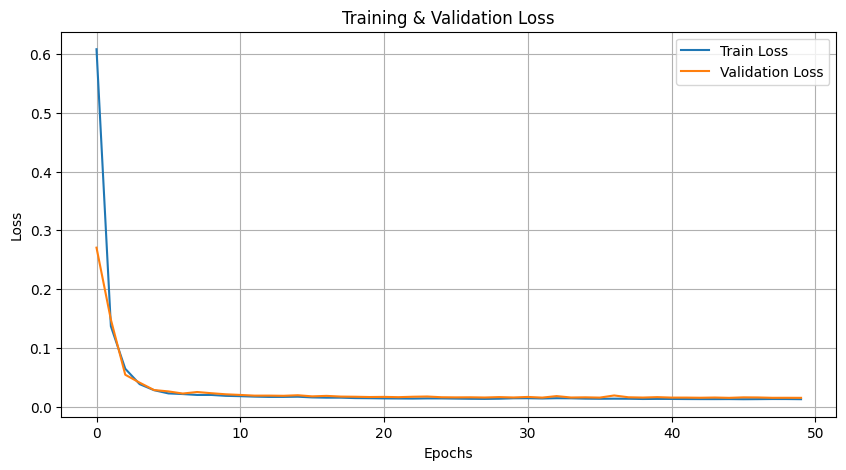

In [156]:

# ===== Plot กราฟ Loss =====
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()


# Test

In [157]:
Y_pred_test_scaled = model.predict([X_test_enc_scaled, Y_test_dec_in_scaled])
print(f"Prediction Shape: {Y_pred_test_scaled.shape}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Prediction Shape: (273, 2, 2)


In [158]:
# แปลงค่ากลับเป็นค่าเดิม
Y_pred_test = scaler_dec.inverse_transform(Y_pred_test_scaled.reshape(-1, Y_pred_test_scaled.shape[-1])).reshape(Y_pred_test_scaled.shape)

# แปลงค่าจริงกลับเป็นค่าเดิม
Y_test_dec_out_original = scaler_dec.inverse_transform(Y_test_dec_out_scaled.reshape(-1, Y_test_dec_out_scaled.shape[-1])).reshape(Y_test_dec_out_scaled.shape)
Y_test_dec_out_original.shape

(273, 2, 2)

In [159]:
Y_test_dec_out_original[: , 0 , 0]

array([29.80554241, 33.79115129, 27.84152348, 29.08583373, 29.94973216,
       30.06242087, 28.7408462 , 30.69658793, 28.68594227, 30.64011157,
       29.88384387, 32.17835913, 29.1629514 , 33.89232985, 29.37166632,
       30.94815652, 30.8782215 , 30.9371325 , 33.09316073, 25.19276066,
       28.65337775, 29.79749686, 29.98275705, 32.55481377, 31.4225918 ,
       30.86868546, 31.92830558, 31.72505897, 32.63956085, 29.01001966,
       32.01895099, 29.02832145, 26.91487745, 30.30292645, 31.29428427,
       27.49536263, 27.2254242 , 28.13248358, 30.99816952, 26.02753579,
       28.98932295, 28.02843931, 31.79139612, 31.55283517, 25.18718194,
       27.61255078, 27.47619002, 30.43049396, 29.26801371, 27.66419324,
       28.45491009, 30.62430386, 29.69905194, 27.10657054, 26.28352445,
       31.07304104, 27.13981813, 27.10695889, 28.92013248, 32.07928028,
       27.54227754, 27.83022254, 26.27014361, 22.56790312, 28.76695848,
       23.83126338, 26.01823251, 27.90090254, 26.94699918, 26.49

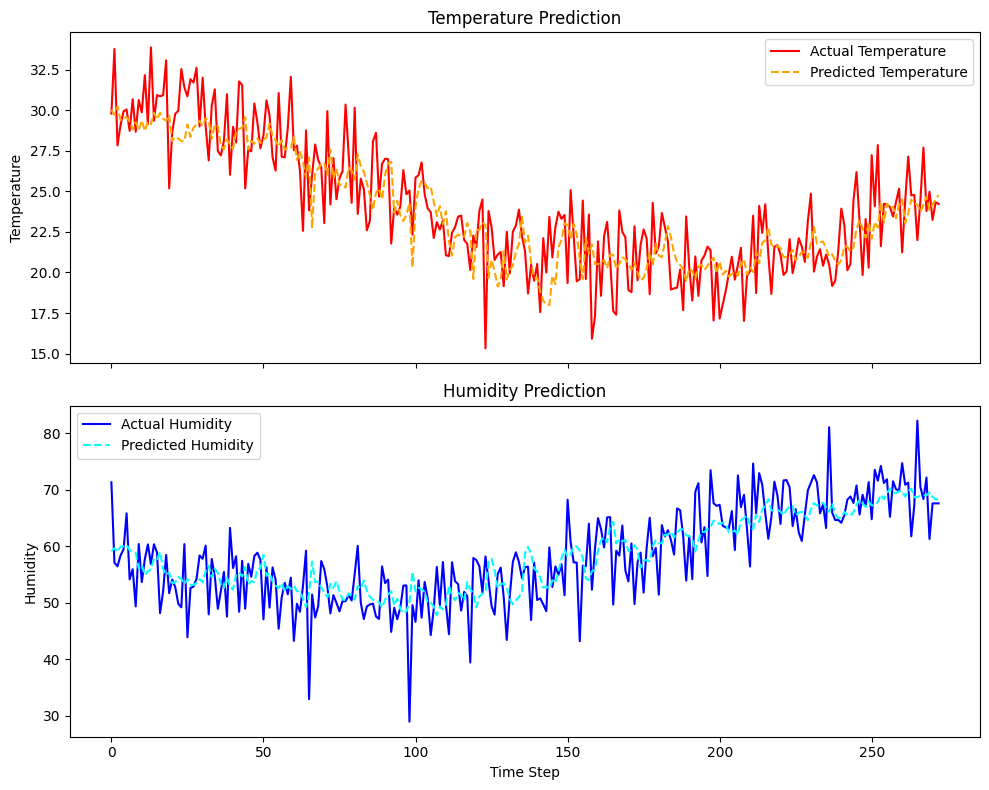

In [160]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

axes[0].plot(Y_test_dec_out_original[:, 0, 0], label="Actual Temperature", color="red")
axes[0].plot(Y_pred_test[:, 0, 0], label="Predicted Temperature", linestyle="dashed", color="orange")
axes[0].set_ylabel("Temperature")
axes[0].set_title("Temperature Prediction")
axes[0].legend()

axes[1].plot(Y_test_dec_out_original[:, 0, 1], label="Actual Humidity", color="blue")
axes[1].plot(Y_pred_test[:, 0, 1], label="Predicted Humidity", linestyle="dashed", color="cyan")
axes[1].set_ylabel("Humidity")
axes[1].set_title("Humidity Prediction")
axes[1].legend()

axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()


In [161]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_temp_scaled = mean_squared_error(Y_test_dec_out_scaled[:, :, 0], Y_pred_test_scaled[:, :, 0])
rmse_temp_scaled = np.sqrt(mse_temp_scaled)
mae_temp_scaled = mean_absolute_error(Y_test_dec_out_scaled[:, :, 0], Y_pred_test_scaled[:, :, 0])

mse_humid_scaled = mean_squared_error(Y_test_dec_out_scaled[:, :, 1], Y_pred_test_scaled[:, :, 1])
rmse_humid_scaled = np.sqrt(mse_humid_scaled)
mae_humid_scaled = mean_absolute_error(Y_test_dec_out_scaled[:, :, 1], Y_pred_test_scaled[:, :, 1])

print("=== Test Score (Before Inverse Transform) ===")
print(f"Temperature - MSE: {mse_temp_scaled:.6f}, RMSE: {rmse_temp_scaled:.6f}, MAE: {mae_temp_scaled:.6f}")
print(f"Humidity - MSE: {mse_humid_scaled:.6f}, RMSE: {rmse_humid_scaled:.6f}, MAE: {mae_humid_scaled:.6f}")

=== Test Score (Before Inverse Transform) ===
Temperature - MSE: 0.012612, RMSE: 0.112302, MAE: 0.090197
Humidity - MSE: 0.014298, RMSE: 0.119575, MAE: 0.091628


In [162]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_temp = mean_squared_error(Y_test_dec_out_original[:, 0, 0], Y_pred_test[:, 0, 0])
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(Y_test_dec_out_original[:, 0, 0], Y_pred_test[:, 0, 0])

mse_humid = mean_squared_error(Y_test_dec_out_original[:, 0, 1], Y_pred_test[:, 0, 1])
rmse_humid = np.sqrt(mse_humid)
mae_humid = mean_absolute_error(Y_test_dec_out_original[:, 0, 1], Y_pred_test[:, 0, 1])

print("=== Test Score ===")
print(f"Temperature - MSE: {mse_temp:.4f}, RMSE: {rmse_temp:.4f}, MAE: {mae_temp:.4f}")
print(f"Humidity - MSE: {mse_humid:.4f}, RMSE: {rmse_humid:.4f}, MAE: {mae_humid:.4f}")

=== Test Score ===
Temperature - MSE: 5.0737, RMSE: 2.2525, MAE: 1.8000
Humidity - MSE: 28.9722, RMSE: 5.3826, MAE: 4.1266
